In [34]:
# --- Importer les bibliothèques nécessaires ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
import plotly.express as px
import joblib



In [ ]:
# --- Charger le dataset ---
from google.colab import files
uploaded = files.upload()  # Importez votre fichier CSV

# Lire le fichier CSV
df = pd.read_csv(list(uploaded.keys())[0])
print("\nAperçu des données :")
df.head()
# Afficher les informations du dataset
print("\nRésumé des colonnes et des types de données :")
print(df.info())

# Afficher les statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe())


Saving athlete_events.csv to athlete_events (1).csv

Aperçu des données :

Résumé des colonnes et des types de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB
None

Statistiques descriptives :
                  ID    

In [ ]:
# --- Préparer les données ---
# Garder uniquement les colonnes importantes
columns_to_keep = ['Sex', 'Age', 'Height', 'Weight', 'Team', 'Sport', 'Medal']
df = df[columns_to_keep]

# Supprimer les lignes avec des valeurs manquantes
df = df.dropna()

# Ajouter une colonne IMC (Indice de Masse Corporelle)
df['BMI'] = df['Weight'] / ((df['Height'] / 100) ** 2)

# Encoder les variables catégoriques
le_sex = LabelEncoder()
df['Sex'] = le_sex.fit_transform(df['Sex'])

le_team = LabelEncoder()
df['Team'] = le_team.fit_transform(df['Team'])

le_sport = LabelEncoder()
df['Sport'] = le_sport.fit_transform(df['Sport'])

# Convertir 'Medal' en variable binaire
df['Medal'] = df['Medal'].notnull().astype(int)

print("\nDonnées après prétraitement :")
df.head()



Données après prétraitement :


,Sex,Age,Height,Weight,Team,Sport,Medal,BMI
40,1,28.0,184.0,85.0,75,25,1,25.106333
41,1,28.0,175.0,64.0,75,22,1,20.897959
42,1,28.0,175.0,64.0,75,22,1,20.897959
44,1,28.0,175.0,64.0,75,22,1,20.897959
48,1,28.0,175.0,64.0,75,22,1,20.897959


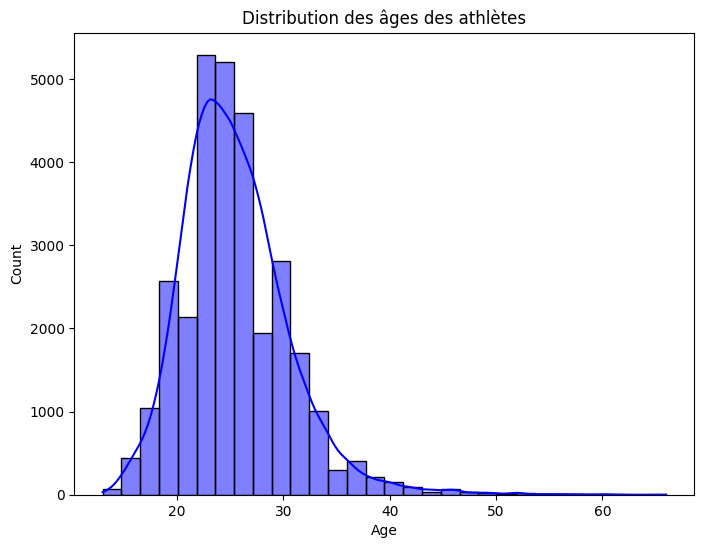

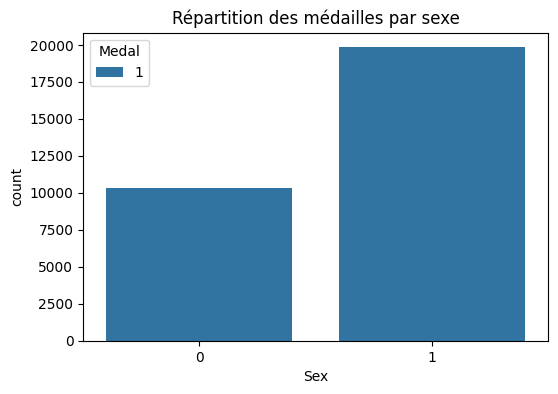

In [ ]:
# --- Visualisations de base ---
# Distribution des âges
plt.figure(figsize=(8, 6))
sns.histplot(df['Age'], kde=True, bins=30, color='blue')
plt.title('Distribution des âges des athlètes')
plt.show()

# Répartition des médailles par sexe
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Sex', hue='Medal')
plt.title('Répartition des médailles par sexe')
plt.show()

# Répartition par pays (Top 10)
top_teams = df['Team'].value_counts().head(10).index
df_top_teams = df[df['Team'].isin(top_teams)]

fig = px.bar(df_top_teams, x='Team', color='Medal', title="Répartition des médailles par pays (Top 10)")
fig.show()


In [ ]:
# --- Diviser les données en caractéristiques et cible ---
X = df.drop('Medal', axis=1)
y = df['Medal']

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraîner un modèle Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy du modèle : {accuracy * 100:.2f}%")
print("\nRapport de classification :\n", classification_report(y_test, y_pred))



Accuracy du modèle : 100.00%

Rapport de classification :
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      6037

    accuracy                           1.00      6037
   macro avg       1.00      1.00      1.00      6037
weighted avg       1.00      1.00      1.00      6037



In [ ]:
# --- Optimisation avec GridSearch ---
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
print("\nMeilleurs paramètres :")
print(grid_search.best_params_)

# Évaluer le modèle optimisé
best_model = grid_search.best_estimator_
y_pred_optimized = best_model.predict(X_test)
print("\nAccuracy après optimisation :", accuracy_score(y_test, y_pred_optimized))



Meilleurs paramètres :
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}

Accuracy après optimisation : 1.0


In [ ]:
# --- Sauvegarder le modèle ---
joblib.dump(best_model, 'medal_predictor.pkl')
print("\nModèle sauvegardé avec succès.")

# Exemple de prédiction
new_athlete = np.array([[1, 25, 180, 75, 10, 5, 23]])  # Exemple : [Sex, Age, Height, Weight, Team, Sport, BMI]
new_athlete_prediction = best_model.predict(new_athlete)
print("\nPrédiction pour un nouvel athlète :", "Gagnera une médaille" if new_athlete_prediction[0] == 1 else "Ne gagnera pas de médaille")

# Télécharger le modèle
from google.colab import files
files.download('medal_predictor.pkl')



Modèle sauvegardé avec succès.

Prédiction pour un nouvel athlète : Gagnera une médaille


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning:

A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.



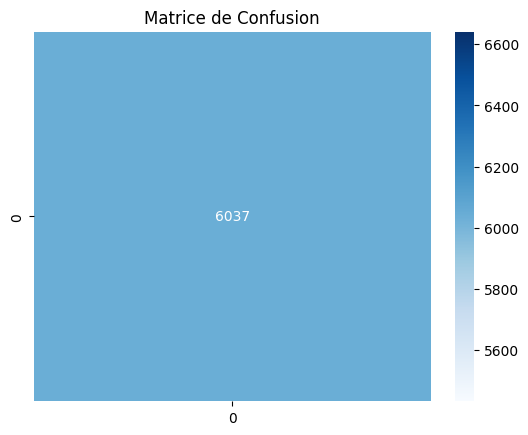

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de Confusion")
plt.show()


In [ ]:
fig = px.histogram(df, x='BMI', color='Medal', barmode='group', title="Distribution de l'IMC par médaille")
fig.show()


In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Validation croisée - Accuracy moyenne : {np.mean(scores):.2f}")


Validation croisée - Accuracy moyenne : 1.00


In [ ]:
# Exemple d'athlète qui pourrait gagner une médaille
athlete_with_medal = np.array([[1, 22, 175, 70, 12, 8, 22.86]])  # [Sex, Age, Height, Weight, Team, Sport, BMI]
prediction_with_medal = best_model.predict(athlete_with_medal)
print("\nPrédiction pour un athlète (cas possible - médaille) :",
      "Gagnera une médaille" if prediction_with_medal[0] == 1 else "Ne gagnera pas de médaille")

# Exemple d'athlète qui pourrait ne pas gagner une médaille
athlete_without_medal = np.array([[0, 30, 160, 55, 15, 20, 21.48]])  # [Sex, Age, Height, Weight, Team, Sport, BMI]
prediction_without_medal = best_model.predict(athlete_without_medal)
print("\nPrédiction pour un athlète (cas possible - pas de médaille) :",
      "Ne gagnera pas de médaille" if prediction_without_medal[0] == 1 else "Ne gagnera pas de médaille")



Prédiction pour un athlète (cas possible - médaille) : Gagnera une médaille

Prédiction pour un athlète (cas possible - pas de médaille) : Ne gagnera pas de médaille


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [ ]:
!pip install ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import joblib
import ipywidgets as widgets
from IPython.display import display

# Charger le modèle
model = joblib.load('medal_predictor.pkl')

# Créer des widgets pour les entrées de l'utilisateur
sex = widgets.Dropdown(
    options=[('Femme', 0), ('Homme', 1)],  # 0 pour Femme, 1 pour Homme
    description='Sexe:',
    disabled=False
)

age = widgets.IntSlider(
    value=22,
    min=18,
    max=100,
    step=1,
    description='Âge:',
    disabled=False
)

height = widgets.IntSlider(
    value=175,
    min=140,
    max=220,
    step=1,
    description='Taille (cm):',
    disabled=False
)

weight = widgets.IntSlider(
    value=70,
    min=30,
    max=200,
    step=1,
    description='Poids (kg):',
    disabled=False
)

team = widgets.IntText(
    value=12,
    description='Équipe:',
    disabled=False
)

sport = widgets.IntText(
    value=8,
    description='Sport:',
    disabled=False
)

# Widget pour afficher l'IMC
bmi_label = widgets.Label(value="IMC: ")

# Calculer l'IMC basé sur la taille et le poids
def compute_bmi(height, weight):
    return weight / ((height / 100) ** 2)

# Fonction pour mettre à jour l'IMC
def update_bmi(*args):
    bmi = compute_bmi(height.value, weight.value)
    bmi_label.value = f"IMC: {bmi:.2f}"

# Mettre à jour l'IMC lorsque les valeurs de taille ou de poids changent
height.observe(update_bmi, 'value')
weight.observe(update_bmi, 'value')

# Fonction pour effectuer la prédiction
def make_prediction(sex, age, height, weight, team, sport):
    bmi = compute_bmi(height, weight)

    # Utiliser l'encodage du sexe fourni par l'utilisateur
    athlete_data = np.array([[sex, age, height, weight, team, sport, bmi]])

    # Affichage des données utilisées pour la prédiction
    print(f"Entrées utilisées pour la prédiction: {athlete_data}")

    # Prédiction avec le modèle
    prediction = model.predict(athlete_data)

    if prediction[0] == 1:
        return "Cet athlète **gagnera une médaille**."
    else:
        return "Cet athlète **ne gagnera pas de médaille**."

# Créer un bouton pour tester un athlète avec médaille
def test_athlete_with_medal():
    # Exemple d'athlète avec médaille (valeurs spécifiques pour gagner)
    athlete_with_medal = np.array([[1, 22, 175, 70, 12, 8, 22.86]])  # [Sex, Age, Height, Weight, Team, Sport, BMI]
    prediction_with_medal = model.predict(athlete_with_medal)

    if prediction_with_medal[0] == 1:
        return "Cet athlète **gagnera une médaille**."


# Créer un bouton pour tester un athlète sans médaille
def test_athlete_without_medal():
    # Exemple d'athlète sans médaille (valeurs spécifiques pour ne pas gagner)
    athlete_without_medal = np.array([[0, 30, 160, 55, 15, 20, 21.48]])  # [Sex, Age, Height, Weight, Team, Sport, BMI]
    prediction_without_medal = model.predict(athlete_without_medal)

    if prediction_without_medal[0] == 1:
        return "Cet athlète ** ne gagnera pas de médaille**."


# Créer les boutons
test_button_with_medal = widgets.Button(description="Tester Athlète (Avec Médaille)")
test_button_with_medal.on_click(lambda x: print(test_athlete_with_medal()))

test_button_without_medal = widgets.Button(description="Tester Athlète (Sans Médaille)")
test_button_without_medal.on_click(lambda x: print(test_athlete_without_medal()))

# Afficher l'interface
display(sex, age, height, weight, team, sport, bmi_label, test_button_with_medal, test_button_without_medal)



Dropdown(description='Sexe:', options=(('Femme', 0), ('Homme', 1)), value=0)

IntSlider(value=22, description='Âge:', min=18)

IntSlider(value=175, description='Taille (cm):', max=220, min=140)

IntSlider(value=70, description='Poids (kg):', max=200, min=30)

IntText(value=12, description='Équipe:')

IntText(value=8, description='Sport:')

Label(value='IMC: ')

Button(description='Tester Athlète (Avec Médaille)', style=ButtonStyle())

Button(description='Tester Athlète (Sans Médaille)', style=ButtonStyle())

Cet athlète ** ne gagnera pas de médaille**.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



Cet athlète **gagnera une médaille**.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names

